In [1]:
import pandas as pd
from backtesting import Backtest
from ipydatagrid import DataGrid
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

C:\Users\barry\CQF\Final Project\ALWorkshop\venv\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# set some defaults and global variables
DATE = "Date"
COMMISSION = 0.002
RESULTS = "Results"

# set some defaults used for charting
default_grid_styling = {
    "background_color": "white",
    "grid_line_color": "black",
    "header_background_color": "mediumseagreen",
    "header_grid_line_color": "black",
    "headerFontStyle": "bold",
}

In [3]:
test_data = pd.read_csv("historical_data/BCHUSD_2024.csv")
test_data.columns = test_data.columns.str.capitalize()
test_data[DATE] = pd.to_datetime(test_data[DATE])
test_data = test_data.set_index(DATE)
test_data = test_data.sort_index()

# Mean Reversion Strategy

The mean reversion strategy is EMA RSI Mean reversion for BCHUSD over 30 minute period

The parameters to be used are:
* RSI Window: 10
* Lower RSI Band: 30
* Upper RSI BAnd: 80
* EMA Window: 70

In [4]:
# import the strategy
from strategies import EmaRsiMeanReversion

In [5]:
# resample data to 30 minute frequency
mr_data = test_data.copy().resample("30min").agg(
                        {"Open": "first",
                         "High": "max",
                         "Low": "min",
                         "Close": "last",
                         "Volume": "sum",
                         "Trade_count": "sum"}
                    )
mr_data = mr_data.dropna()

In [6]:
bt = Backtest(mr_data, EmaRsiMeanReversion, cash=1000000, commission=COMMISSION)
bt.run()
bt.plot(filename="plots/EmaRsiBacktest2024.html", resample=False)
mr_results = pd.DataFrame(bt._results)

C:\Users\barry\CQF\Final Project\ALWorkshop\venv\lib\site-packages\backtesting\_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')


In [27]:
mr_results_summary = mr_results.copy()
mr_results_summary.columns = [RESULTS]
mr_results_summary = mr_results_summary.iloc[:-2]
mr_results_summary[RESULTS] = mr_results_summary[RESULTS].astype(str)
mr_results_grid = DataGrid(mr_results_summary, layout={"height": "650px", "width": "500px"})
mr_results_grid.grid_style = default_grid_styling
mr_results_grid.auto_fit_columns = True
mr_results_grid

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

In [8]:
mr_equity_curve = pd.DataFrame(bt._results._equity_curve)
mr_trades = pd.DataFrame(bt._results._trades)

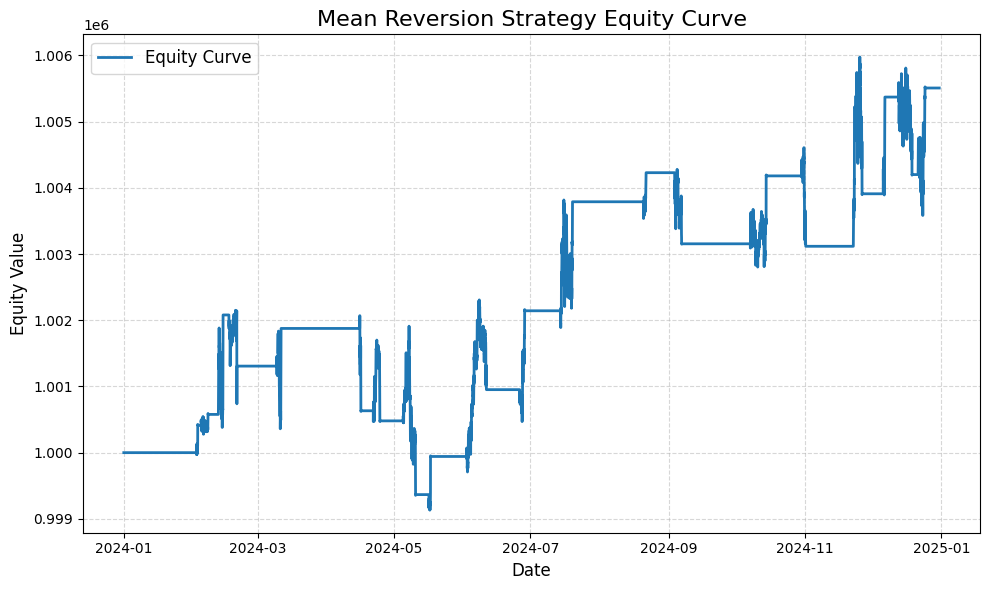

In [31]:
# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(mr_equity_curve.index, mr_equity_curve["Equity"], label="Equity Curve", linewidth=2)
plt.title("Mean Reversion Strategy Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Equity Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

# Trend Following Strategy

The MACD ADX trend following strategy for BCHUSD over the 60 minute interval was arguably the best performing stragey, with higher returns relative to the other strategies. 

The optimal paramaters to be used are:
* ADX Window: 13
* ADX Threhsold: 25
* ADX Exit Threshold: 20
* MACD Short Window: 14
* MACD Long Window: 28
* MACD Signal Window: 9

In [9]:
from strategies import MacdAdxTrendFollowing

In [10]:
# resample data to 30 minute frequency
tf_data = test_data.copy().resample("30min").agg(
                        {"Open": "first",
                         "High": "max",
                         "Low": "min",
                         "Close": "last",
                         "Volume": "sum",
                         "Trade_count": "sum"}
                    )
tf_data = tf_data.dropna()

In [11]:
bt = Backtest(tf_data, MacdAdxTrendFollowing, cash=1000000, commission=COMMISSION)
bt.run()
bt.plot(filename="plots/MacdAdxBacktest2024.html", resample=False)
tf_results = pd.DataFrame(bt._results)

C:\Users\barry\CQF\Final Project\ALWorkshop\venv\lib\site-packages\backtesting\_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')


In [12]:
tf_results_summary = tf_results.copy()
tf_results_summary.columns = [RESULTS]
tf_results_summary = tf_results_summary.iloc[:-2]
tf_results_summary[RESULTS] = tf_results_summary[RESULTS].astype(str)
tf_results_grid = DataGrid(tf_results_summary, layout={"height": "650px", "width": "500px"})
tf_results_grid.grid_style = default_grid_styling
tf_results_grid.auto_fit_columns = True

In [28]:
tf_results_grid

DataGrid(auto_fit_columns=True, auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_render…

In [14]:
tf_equity_curve = pd.DataFrame(bt._results._equity_curve)

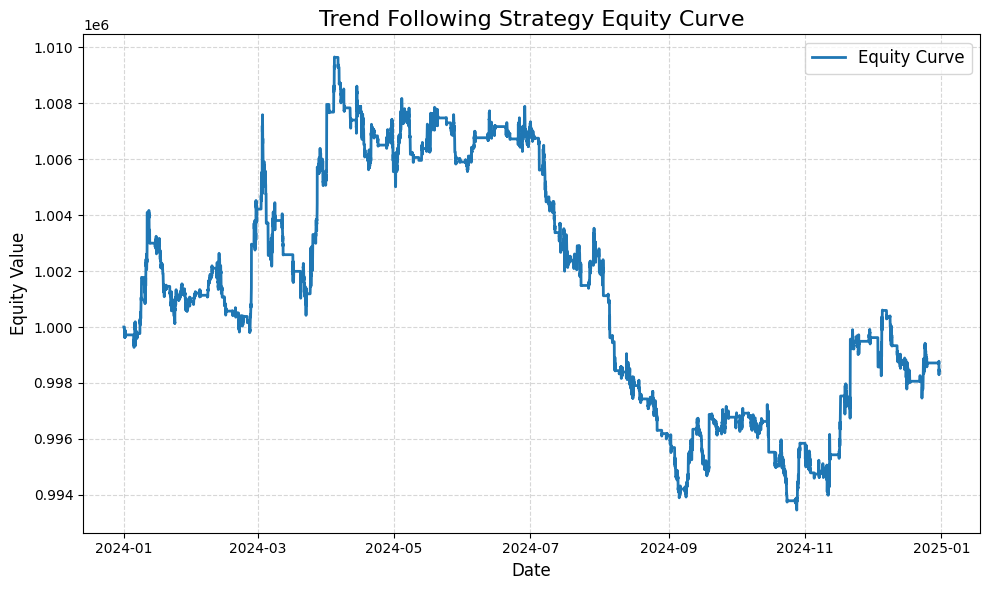

In [33]:
# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(tf_equity_curve.index, tf_equity_curve["Equity"], label="Equity Curve", linewidth=2)
plt.title("Trend Following Strategy Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Equity Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
max_drawdown_perc = tf_results.loc["Max. Drawdown [%]"][0]
avg_drawdown_perc = tf_results.loc["Avg. Drawdown [%]"][0]

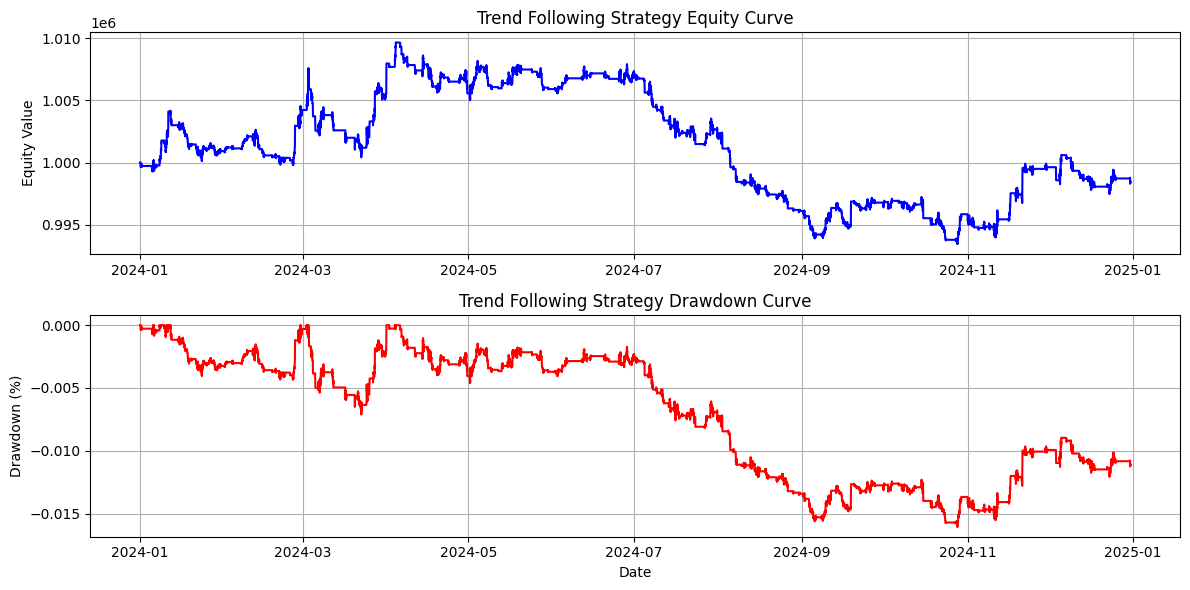

In [36]:
# Calculate drawdowns
tf_equity_curve["Peak"] = tf_equity_curve["Equity"].cummax()
tf_equity_curve["Drawdown"] = (tf_equity_curve["Equity"] - tf_equity_curve["Peak"]) / tf_equity_curve["Peak"]

# Plot equity curve and drawdown
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tf_equity_curve.index, tf_equity_curve["Equity"], label="Equity Curve", color="blue")
plt.title("Trend Following Strategy Equity Curve")
plt.ylabel("Equity Value")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(tf_equity_curve.index, tf_equity_curve["Drawdown"], label="Drawdown", color="red")
plt.title("Trend Following Strategy Drawdown Curve")
plt.ylabel("Drawdown (%)")
plt.xlabel("Date")
plt.grid(True)

plt.tight_layout()
plt.show()

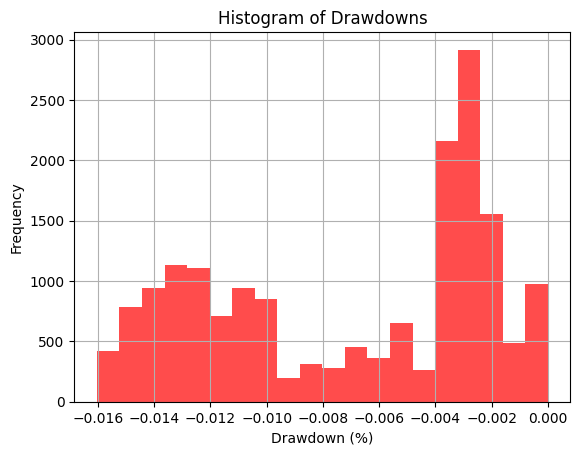

In [18]:
plt.hist(tf_equity_curve["Drawdown"], bins=20, color="red", alpha=0.7)
plt.title("Histogram of Drawdowns")
plt.xlabel("Drawdown (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
tf_trades = pd.DataFrame(bt._results._trades)

## Sharpe ratio

In [49]:
# get 3 Month T-bill rate to use a Risk free rate for 2024
# got from FRED - 3-Month Treasury Bill Secondary Market Rate, Discount Basis
rf_rates = pd.read_csv("historical_data/DTB3.csv")
rf_rates.columns = rf_rates.columns.str.upper()
rf_rates["OBSERVATION_DATE"] = pd.to_datetime(rf_rates["OBSERVATION_DATE"])
rf_rates = rf_rates.set_index("OBSERVATION_DATE")
rf_rates = rf_rates.sort_index()
rf_rate = rf_rates["DTB3"].mean()
rf_rate

4.97004

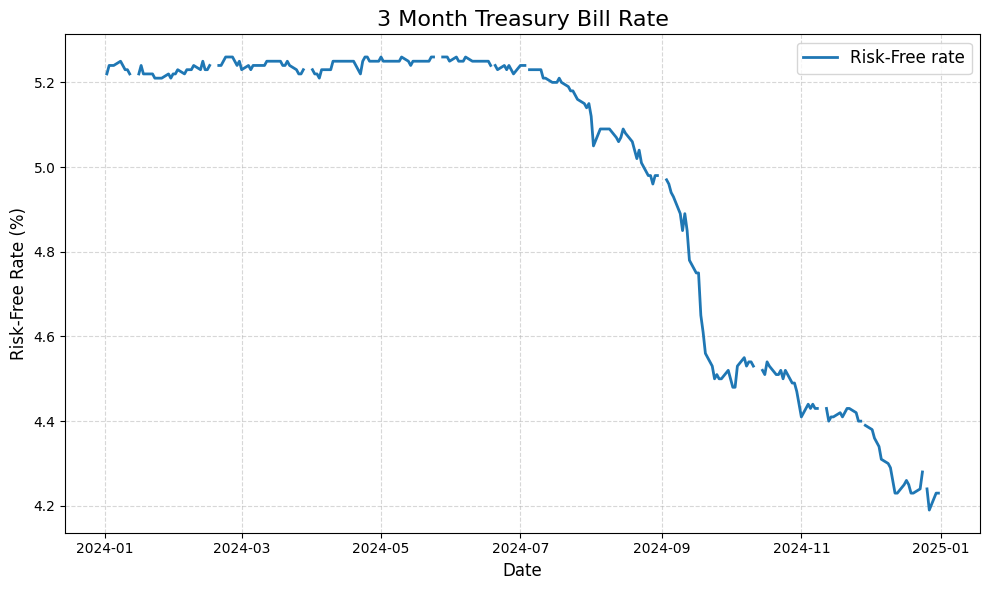

In [61]:
# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(rf_rates.index, rf_rates["DTB3"], label="Risk-Free rate", linewidth=2)
plt.title("3 Month Treasury Bill Rate", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Risk-Free Rate (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [55]:
ticks_per_day = 48
trading_days = 365
annulaisation_factor = ticks_per_day * trading_days
risk_free_rate = rf_rate / 100

# calc sharpe ratio
tf_equity_curve["Return"] = tf_equity_curve["Equity"].pct_change()
tf_equity_curve = tf_equity_curve.dropna(subset=["Return"])

mean_return = tf_equity_curve["Return"].mean() * annulaisation_factor
std_dev_returns = tf_equity_curve["Return"].std() * (annulaisation_factor ** 0.5)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev_returns
sharpe_ratio

-4.684506196082063

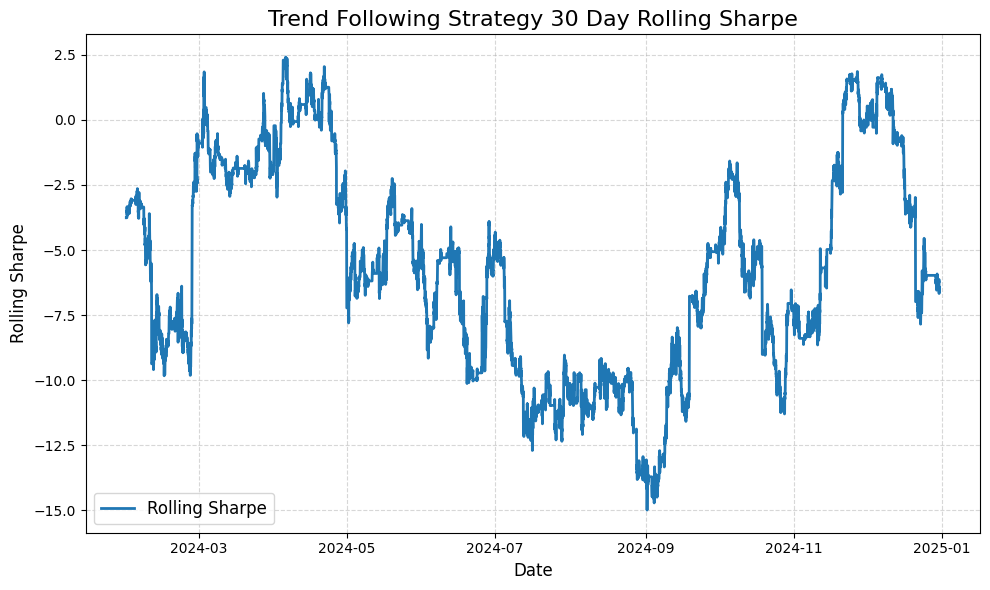

In [62]:
# Rolling Sharpe Ratio function
def rolling_sharpe(returns):
    ticks_per_day = 48
    annualization_factor = ticks_per_day * 365  # For 24/7 crypto markets

    mean_return = returns.mean()
    std_return = returns.std()

    # Avoid division by zero
    if std_return == 0:
        return 0

    # Annualise the Sharpe ratio
    sharpe = (mean_return * annualization_factor - risk_free_rate) / (std_return * np.sqrt(annualization_factor))
    return sharpe

# daily rolling Sharpe
tf_equity_curve["Rolling Sharpe"] = tf_equity_curve["Return"].rolling(48*30).apply(rolling_sharpe)

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(tf_equity_curve.index, tf_equity_curve["Rolling Sharpe"], label="Rolling Sharpe", linewidth=2)
plt.title("Trend Following Strategy 30 Day Rolling Sharpe", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Rolling Sharpe", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

## Calculate VaR

In [88]:
# Historical Simulation Method
def historical_var(returns, portfolio_value, confidence_level):
    """
    Calculate 1-Day VaR for 30 minute data using Historical Simulation.
    """
    # Aggregate returns over daily intervals
    daily_returns = [
        np.sum(returns[i:i + 48])  # Aggregate 48 intervals for daily returns
        for i in range(0, len(returns) - 48, 48)
    ]
    sorted_returns = np.sort(returns)  # Sort returns in ascending order
    percentile_index = int((1 - confidence_level) * len(sorted_returns))
    var_percentile = sorted_returns[percentile_index]
    var_value = portfolio_value * abs(var_percentile)
    return var_value, var_percentile

# Parametric (Variance-Covariance) Method
def parametric_var(returns, portfolio_value, confidence_level):
    """
    Calculate 1-Day VaR for 30 minute data using Parametric (Variance-Covariance) Method.
    """
    mean_return = np.mean(returns)
    scaling_factor = np.sqrt(48) # There are 48 30-minute periods in a day
    std_dev = np.std(returns) * scaling_factor
    z_score = norm.ppf(1 - confidence_level)  # Z-score for the confidence level
    var_percentile = mean_return + z_score * std_dev
    var_value = portfolio_value * abs(var_percentile)
    return var_value, var_percentile

In [91]:
# Calculate VaR
oned_var_historical_95, oned_percentile_historical_95 = historical_var(returns=tf_equity_curve["Return"].dropna(), portfolio_value=1000000, confidence_level=0.95)
oned_var_historical_99, oned_percentile_historical_99 = historical_var(returns=tf_equity_curve["Return"].dropna(), portfolio_value=1000000, confidence_level=0.99)

oned_var_parametric_95, oned_percentile_parametric_95 = parametric_var(returns=tf_equity_curve["Return"].dropna(), portfolio_value=1000000, confidence_level=0.95)
oned_var_parametric_99, oned_percentile_parametric_99 = parametric_var(returns=tf_equity_curve["Return"].dropna(), portfolio_value=1000000, confidence_level=0.99)

print(f"Historical 1-day VaR (95% confidence): ${oned_var_historical_95:,.2f}, Percentile: {oned_percentile_historical_95:.4f}")
print(f"Parametric 1-day VaR (95% confidence): ${oned_var_parametric_95:,.2f}, Percentile: {oned_percentile_parametric_95:.4f}")
print("\n")
print(f"Historical 1-day VaR (99% confidence): ${oned_var_historical_99:,.2f}, Percentile: {oned_percentile_historical_99:.4f}")
print(f"Parametric 1-day VaR (99% confidence): ${oned_var_parametric_99:,.2f}, Percentile: {oned_percentile_parametric_99:.4f}")

Historical 1-day VaR (95% confidence): $112.20, Percentile: -0.0001
Parametric 1-day VaR (95% confidence): $940.97, Percentile: -0.0009


Historical 1-day VaR (99% confidence): $252.73, Percentile: -0.0003
Parametric 1-day VaR (99% confidence): $1,330.80, Percentile: -0.0013


In [94]:
# scale for 10 days
tend_var_historical_95 = oned_var_historical_95 * np.sqrt(10)
tend_var_parametric_95 = oned_var_parametric_95 * np.sqrt(10)

tend_var_historical_99 = oned_var_historical_99 * np.sqrt(10)
tend_var_parametric_99 = oned_var_parametric_99 * np.sqrt(10)

print(f"Historical 10-day VaR (95% confidence): ${tend_var_historical_95:,.2f}")
print(f"Parametric 10-day VaR (95% confidence): ${tend_var_parametric_95:,.2f}")
print("\n")
print(f"Historical 10-day VaR (99% confidence): ${tend_var_historical_99:,.2f}")
print(f"Parametric 10-day VaR (99% confidence): ${tend_var_parametric_99:,.2f}")

Historical 10-day VaR (95% confidence): $354.81
Parametric 10-day VaR (95% confidence): $2,975.62


Historical 10-day VaR (99% confidence): $799.21
Parametric 10-day VaR (99% confidence): $4,208.36


## Calculate 1-Day Rolling VaR

In [106]:
def rolling_historical_var(returns, portfolio_value, confidence_level):
    """
    Calculate Rolling 1-Day VaR using Historical Simulation for 30-minute data.
    """
    # Define the rolling window size (1 day = 48 intervals)
    rolling_window_size = 48

    # Initialize an array to store rolling VaR values
    rolling_var_values = []

    # Loop over the data to compute rolling VaR
    for i in range(len(returns) - rolling_window_size):
        # Extract the rolling window of 48 intervals
        window_returns = returns[i:i + rolling_window_size]

        # Aggregate returns over the window to simulate daily returns
        daily_return = np.sum(window_returns)

        # Sort the returns and find the percentile for VaR
        sorted_window_returns = np.sort(window_returns)
        percentile_index = int((1 - confidence_level) * len(sorted_window_returns))
        var_percentile = sorted_window_returns[percentile_index]
        var_value = portfolio_value * abs(var_percentile)

        # Append the VaR value for this window
        rolling_var_values.append(var_value)

    return rolling_var_values


def rolling_parametric_var(returns, portfolio_value, confidence_level):
    """
    Calculate Rolling 1-Day VaR using Parametric (Variance-Covariance) Method for 30-minute data.
    """
    # Define the rolling window size (1 day = 48 intervals)
    rolling_window_size = 48

    # Initialize an array to store rolling VaR values
    rolling_var_values = []

    # Loop over the data to compute rolling VaR
    for i in range(len(returns) - rolling_window_size):
        # Extract the rolling window of 48 intervals
        window_returns = returns[i:i + rolling_window_size]

        # Compute mean and standard deviation for the window
        mean_return = np.mean(window_returns)
        scaling_factor = np.sqrt(48)  # Scale for 1 day
        std_dev = np.std(window_returns) * scaling_factor

        # Calculate VaR using the z-score
        z_score = norm.ppf(1 - confidence_level)
        var_percentile = mean_return + z_score * std_dev
        var_value = portfolio_value * abs(var_percentile)

        # Append the VaR value for this window
        rolling_var_values.append(var_value)

    return rolling_var_values

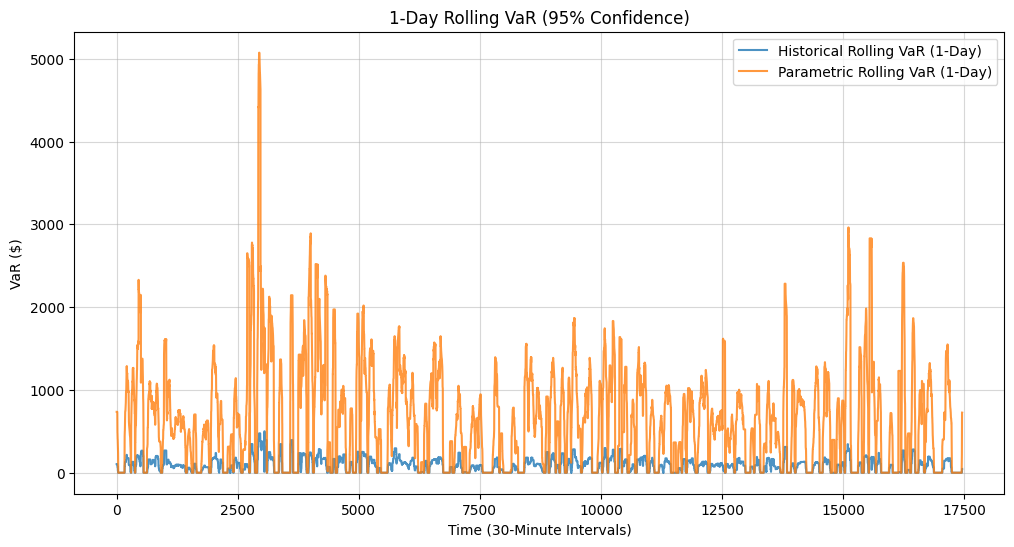

In [107]:
# Calculate 1-Day Rolling Historical VaR at 95% confidence
rolling_var_historical_95 = rolling_historical_var(tf_equity_curve["Return"], 1000000, 0.95)

# Calculate 1-Day Rolling Parametric VaR at 95% confidence
rolling_var_parametric_95 = rolling_parametric_var(tf_equity_curve["Return"], 1000000, 0.95)

# Plot Rolling VaR
plt.figure(figsize=(12, 6))
plt.plot(rolling_var_historical_95, label="Historical Rolling VaR (1-Day)", alpha=0.8)
plt.plot(rolling_var_parametric_95, label="Parametric Rolling VaR (1-Day)", alpha=0.8)
plt.title("1-Day Rolling VaR (95% Confidence)")
plt.xlabel("Time (30-Minute Intervals)")
plt.ylabel("VaR ($)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

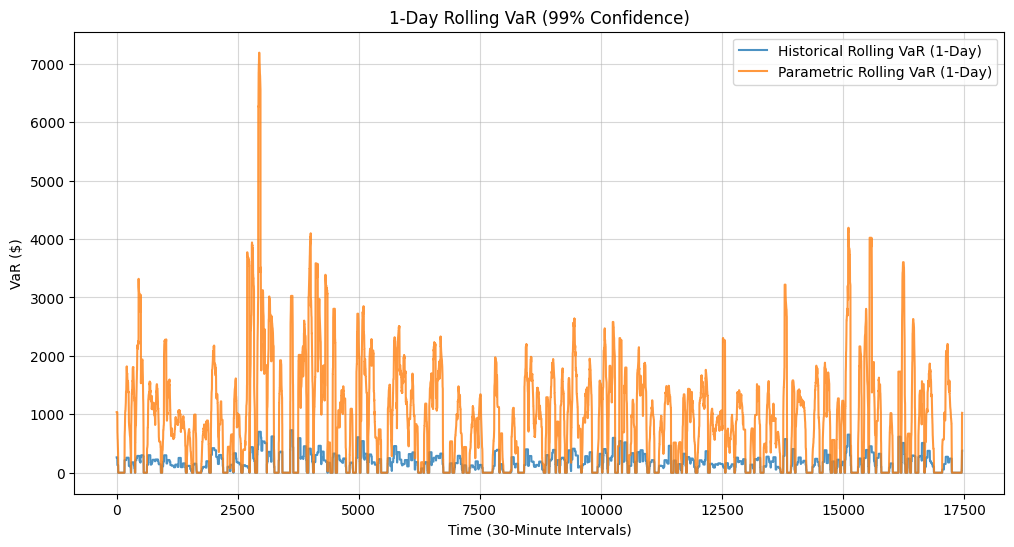

In [108]:
# Calculate 1-Day Rolling Historical VaR at 99% confidence
rolling_var_historical_99 = rolling_historical_var(tf_equity_curve["Return"], 1000000, 0.99)

# Calculate 1-Day Rolling Parametric VaR at 99% confidence
rolling_var_parametric_99 = rolling_parametric_var(tf_equity_curve["Return"], 1000000, 0.99)

# Plot Rolling VaR
plt.figure(figsize=(12, 6))
plt.plot(rolling_var_historical_99, label="Historical Rolling VaR (1-Day)", alpha=0.8)
plt.plot(rolling_var_parametric_99, label="Parametric Rolling VaR (1-Day)", alpha=0.8)
plt.title("1-Day Rolling VaR (99% Confidence)")
plt.xlabel("Time (30-Minute Intervals)")
plt.ylabel("VaR ($)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

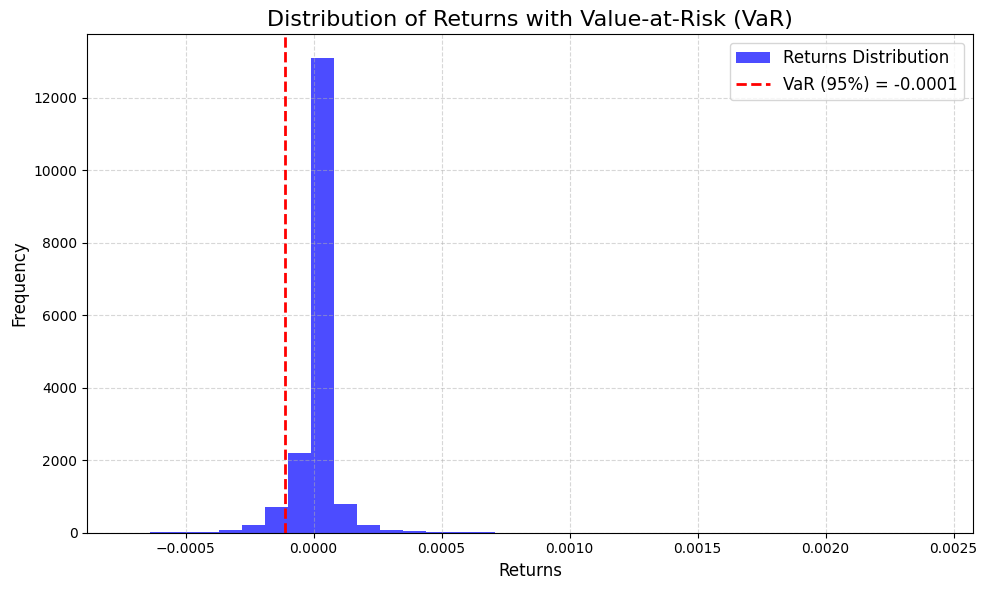

In [109]:
# Plotting the histogram of returns and VaR
plt.figure(figsize=(10, 6))
plt.hist(tf_equity_curve["Return"], bins=35, color='blue', alpha=0.7, label="Returns Distribution")
plt.axvline(VaR, color='red', linestyle='--', linewidth=2, label=f"VaR ({confidence_level*100:.0f}%) = {VaR:.4f}")

# Adding titles and labels
plt.title("Distribution of Returns with Value-at-Risk (VaR)", fontsize=16)
plt.xlabel("Returns", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5, linestyle='--')

# Show plot
plt.tight_layout()
plt.show()

## Other Metrics for Short-Term Trading

In [60]:
avg_trade_duration = tf_results.loc["Avg. Trade Duration"][0]
max_trade_duration = tf_results.loc["Max. Trade Duration"][0]
win_rate = tf_results.loc["Win Rate [%]"][0]
print(f"Avg trade duration: {avg_trade_duration}")
print(f"Max trade duration: {max_trade_duration}") 
print(f"Win Rate: {round(win_rate, 2)}%")

Avg trade duration: 0 days 19:22:00
Max trade duration: 3 days 14:00:00
Win Rate: 35.96%
